# 자전거 대여량 예측 모델 실습

## 실습 목표
----
- sklearn의 model을 사용하여 Regressor를 학습한다.
- 생성한 Regressor의 성능 개선을 위한 방법을 이해한다.
- Regressor에서 사용 가능한 주요 성능 지표를 이해한다.

## 문제 정의
----

https://www.kaggle.com/c/bike-sharing-demand

- 시간 - 시간별 타임 스탬프
- 계절 - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
- 휴일 - whether the day is considered a holiday
- 주간 - whether the day is neither a weekend nor holiday
- 날씨 -
    - 1: 맑음, Few clouds, Partly cloudy, Partly cloudy
    - 2: 안개낌 + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: 약간 눈내림, 약간 비 + 천둥번개 + Scattered 구름, 약간의 비 + Scattered 구름
    - 4: 소나기 + 우박 + 천둥번개 + 안개, 눈 + 짙은 안개
- 온도 - temperature in Celsius
- 체감온도 - "feels like" temperature in Celsius
- 습도 - relative humidity
- 풍량 - wind speed
- 미가입 - number of non-registered user rentals initiated
- 가입 - number of registered user rentals initiated
- 렌탈수 - number of total rentals (Dependent Variable)

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./dataset/exercise2.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [35]:
df.shape

(10886, 12)

## 데이터 탐색

----

In [36]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


<Axes: xlabel='count', ylabel='Count'>

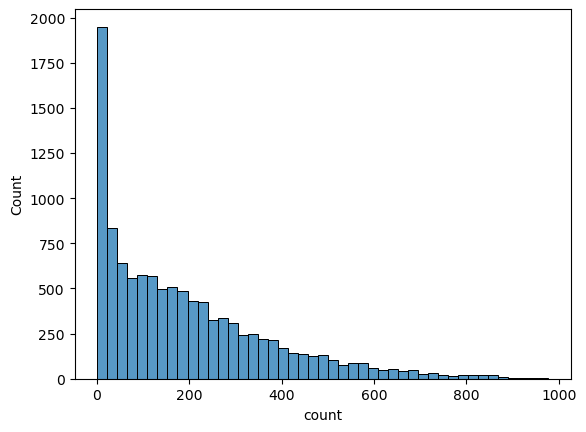

In [37]:
sns.histplot(x=df['count'])

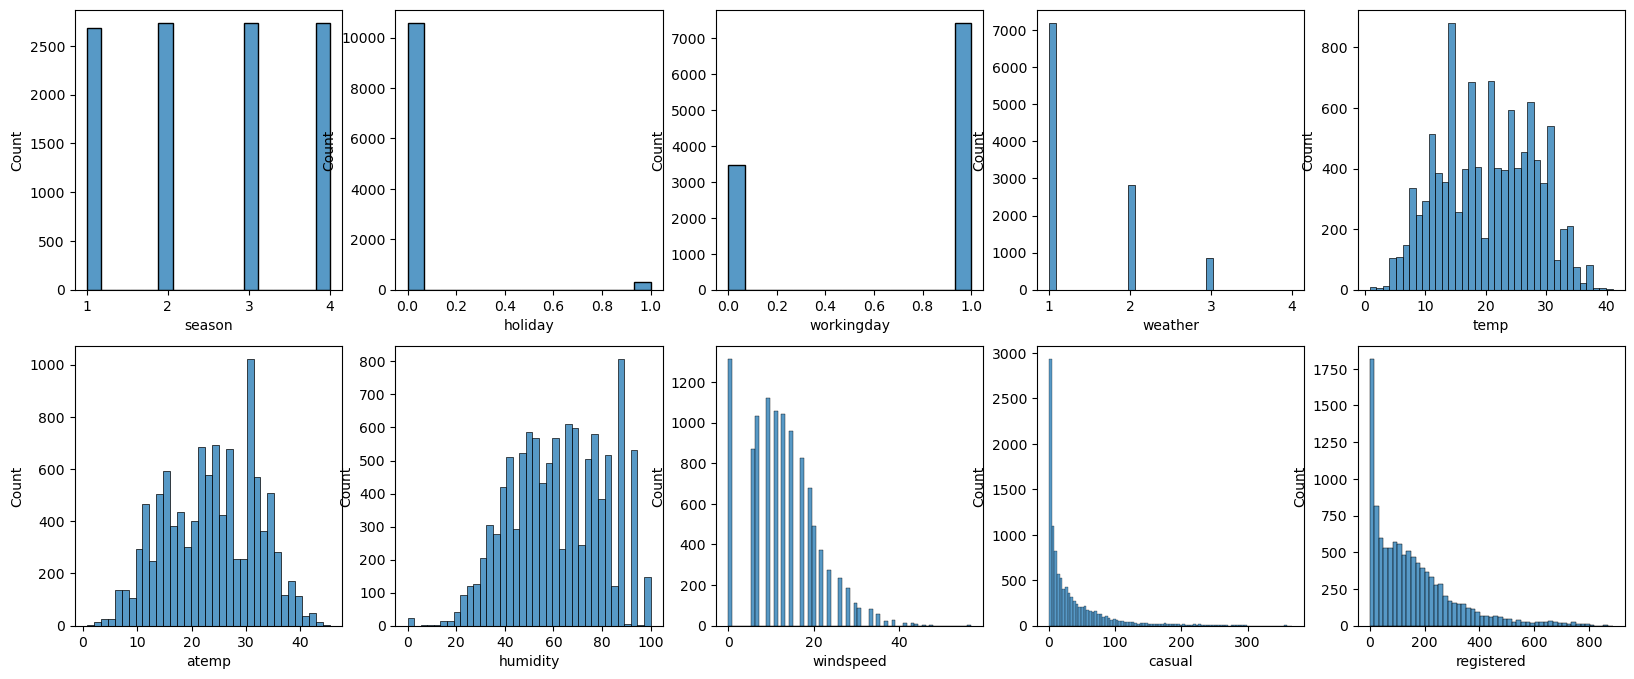

In [38]:
nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(20, 8)

for i in range(nrows):
    for j in range(ncols):
        attr = i * ncols + j + 1
        sns.histplot(x = df.columns[attr], data=df, ax=axes[i][j])

/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_3377/58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

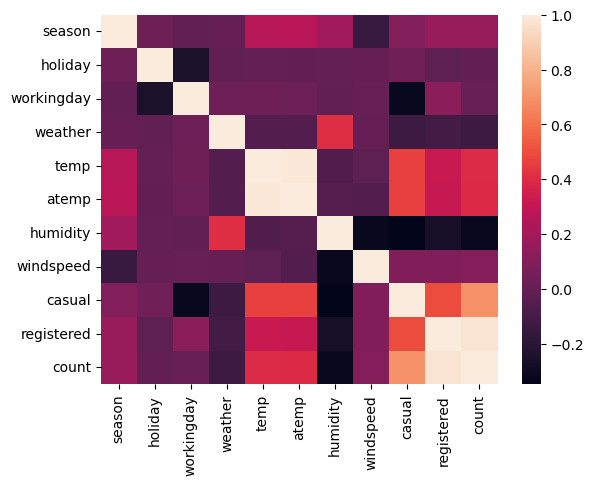

In [39]:
sns.heatmap(df.corr())

## 주요 코드 미리 보기
----
1. 데이터 분할
2. 모델 인스턴스 생성
3. 모델 학습
4. 모델 평가

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

Y = df['count']
X = df.drop(['datetime', 'count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

mean_squared_log_error(y_test, y_pred)

1.5969342176785545e-29

<Axes: >

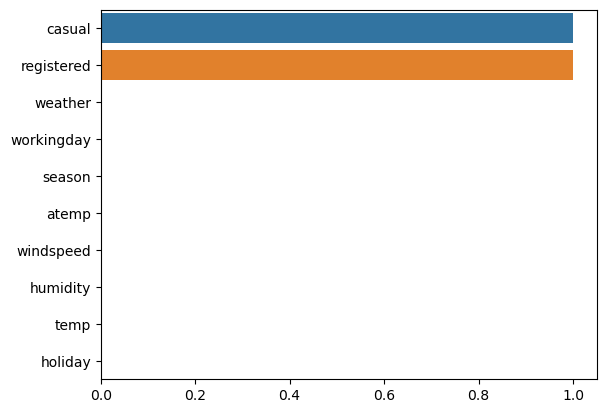

In [41]:
coef = pd.Series(lr_model.coef_, index=X.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 코드 개선하기
----
- Data 관점
    - 의미있는 feature 생성
    - 불필요한 feature 삭제
    - 데이터 형태 변환 : scaling, encoding

- Model 관점
    - Linear Regressor
    - RandomForest Regressor
    - XGBRegressor
    - LGBMRgressor

### Data 관점

#### 의미있는 feature 생성

In [42]:
df['datetime'] = df['datetime'].astype('datetime64')
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

#### 불필요한 feature 삭제

In [43]:
df.drop(['datetime','casual','registered'], axis=1,inplace=True)

#### 데이터 형태 변환

##### y를 정규분포로

<Axes: xlabel='count', ylabel='Count'>

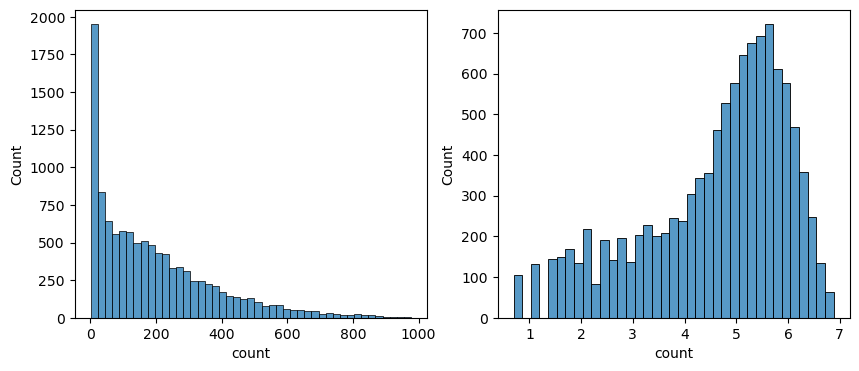

In [44]:
y_log = np.log1p(Y)

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(10, 4)
sns.histplot(Y, ax=axes[0])
sns.histplot(y_log, ax=axes[1])

##### categorical 변수 원핫인코딩

In [45]:
df = pd.get_dummies(df, columns=['year', 'month', 'day', 'hour', 'holiday',
                                              'workingday','season','weather'])

In [46]:
df.columns

Index(['temp', 'atemp', 'humidity', 'windspeed', 'count', 'year_2011',
       'year_2012', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'holiday_0', 'holiday_1',
       'workingday_0', 'workingday_1', 'season_1', 'season_2', 'season_3',
       'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

In [48]:
Y = y_log
X = df.drop(['count'], axis=1, inplace=False)

##### z-score 변환

In [49]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_X = sc.fit_transform(X)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.3, random_state=42)

In [51]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
mean_squared_log_error(np.expm1(y_test), np.expm1(y_pred))

0.3430031324127668

In [53]:
coef = pd.Series(lr_model.coef_, index=X.columns)
coef_sort = coef.sort_values(ascending=False)
coef_sort.head(10)

season_2        8.663378e+12
month_3         8.256037e+12
month_2         8.256037e+12
month_1         8.184737e+12
workingday_0    1.580653e+12
workingday_1    1.580653e+12
season_4        1.377933e+12
day_17          7.163577e+11
day_5           7.163577e+11
day_9           7.163577e+11
dtype: float64

### Model 관점

In [54]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)

model_list = [lr_model, rf_model, xgb_model, lgbm_model]
for model in model_list:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    m = model.__class__.__name__
    score = mean_squared_log_error(np.expm1(y_test), np.expm1(y_pred))
    print('{0} msle: {1:.3f}'.format(m, score))

LinearRegression msle: 0.343
RandomForestRegressor msle: 0.124
XGBRegressor msle: 0.115
LGBMRegressor msle: 0.110
